# Ejercicio 4: Modelo Probabilístico

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [44]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
corpus = newsgroups.data
target = newsgroups.target
target_names = newsgroups.target_names

## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [45]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

In [46]:
# Construcción de la matriz de términos (TF)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
# Calcular la frecuencia de documentos (DF)
df = (X > 0).sum(axis=0).A1
# Calcular TF-IDF con sklearn
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(corpus)
# Crear un DataFrame con los términos y sus frecuencias
tfidf = pd.DataFrame.sparse.from_spmatrix(
    X_tfidf,
    columns=tfidf_vectorizer.get_feature_names_out()
)
# Añadir la columna de etiquetas
tfidf['target'] = target
# Añadir la columna de nombres de categorías
tfidf['target_names'] = [target_names[i] for i in target]

print(tfidf.head())

   00  000  0000  00000  000000  00000000  0000000004  00000000b  00000001  \
0   0    0     0      0       0         0           0          0         0   
1   0    0     0      0       0         0           0          0         0   
2   0    0     0      0       0         0           0          0         0   
3   0    0     0      0       0         0           0          0         0   
4   0    0     0      0       0         0           0          0         0   

   00000001b  ...  zzvsi  zzy_3w  zzz  zzzoh  zzzzzz  zzzzzzt  ³ation  ýé  \
0          0  ...      0       0    0      0       0        0       0   0   
1          0  ...      0       0    0      0       0        0       0   0   
2          0  ...      0       0    0      0       0        0       0   0   
3          0  ...      0       0    0      0       0        0       0   0   
4          0  ...      0       0    0      0       0        0       0   0   

   ÿhooked              target_names  
0        0          rec.sport

## Parte 2: Ranking de documentos usando TF-IDF

### Actividad

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

## Crear el vector consulta

In [47]:
query = "jersey"

In [48]:
query_vect = tfidf_vectorizer.transform([query])
print(query_vect)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 134410)>
  Coords	Values
  (0, 68989)	1.0


### Calcular la similitud coseno

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
 # dist arreglo de similitudes de la consulta y cada documento entre [0-1]
dist = cosine_similarity(query_vect, X).flatten()
print(dist)

[0.05292561 0.         0.         ... 0.         0.         0.        ]


### Generar el ranking y mostrar tabla

In [50]:
top_k = 50

# Ranking de indices debe ser una lista de enteros
ranking_indices = dist.argsort()[::-1] # argsort devuelve índices de menor a mayor y con [::1] invertimos ese orden

# Construcción del DataFrame
resultados = pd.DataFrame({
    'Ranking': range(1, top_k + 1),
    'Documento': [corpus[i][:40].replace('\n', ' ') + '...' for i in ranking_indices[:top_k]],
    'Similitud coseno': [dist[i] for i in ranking_indices[:top_k]],
    #'Categoría': [target_names[target[i]] for i in ranking_indices[:top_k]] #
})

print(resultados)

    Ranking                                     Documento  Similitud coseno
0         1         $200 in Glassboro, New Jersey  :( ...          0.447214
1         2  \tDon't forget Paul Ysebaert, ex-Devil.  ...          0.218218
2         3   Boston                           2 2 0--...          0.209083
3         4   cd's for sale:  1. jon bon jovi - new je...          0.176777
4         5   Does anyone here know where I can find a...          0.174078
5         6   HELP!  I'm stuck here at a computer in N...          0.171499
6         7   Philadelphia                     1 1 2 1...          0.167705
7         8   s:   I have a 1991 Toyota Camry Deluxe f...          0.145865
8         9    I had heard(perhaps incorrectly) that w...          0.142857
9        10    Not to mention the thread about selling...          0.138675
10       11   Thanks to all who replied to my initial ...          0.124035
11       12   \tI just went through this mess in New J...          0.123091
12       13 

## Parte 3: Ranking con BM25

### Actividad

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

### Libreria BM25

In [51]:
from rank_bm25 import BM25Okapi

tokenized_corpus = [doc.split() for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)
# Tokenizar la consulta
tokenized_query = query.split()
# Obtener los scores BM25 para la consulta
scores_bm25 = bm25.get_scores(tokenized_query)

# Ranking de índices BM25 
ranking_indices_bm25 = scores_bm25.argsort()[::-1]
resultados_bm25 = pd.DataFrame({
    'Ranking BM25': range(1, top_k + 1),
    'Documento': [corpus[i][:40].replace('\n', ' ') + '...' for i in ranking_indices_bm25[:top_k]],
    'Score BM25': [scores_bm25[i] for i in ranking_indices_bm25[:top_k]]
})
print(resultados_bm25)


    Ranking BM25                                      Documento  Score BM25
0              1    cd's for sale:  1. jon bon jovi - new je...   13.464986
1              2     I think that Mike Foligno was the capta...   10.686512
2              3    RA>    Here's the point: there are far t...    8.034023
3              4    The FLYERS closed out the season last ni...    2.162020
4              5     Probably keep quiet and take it, lest t...    0.000000
5              6    I have an Alesis HR-16 drum machine for ...    0.000000
6              7     I am asking you to believe in things no...    0.000000
7              8    Hello,      I am having a small problem ...    0.000000
8              9                                    Anaheim....    0.000000
9             10    I never thought I'd contribute to a Gate...    0.000000
10            11         Well, I'm a Wings fan and I think t...    0.000000
11            12    On 21 Apr 93 00:07:20 GMT, Theodore A. K...    0.000000
12          

## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

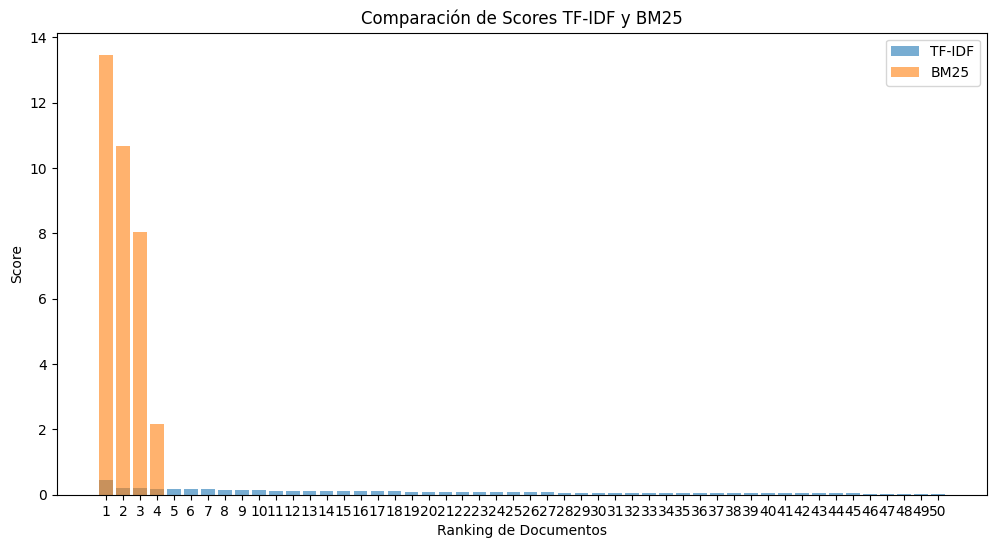

In [52]:
# Gráfico de barras para visualizar los scores por cada documento tfidf y bm25
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(resultados['Ranking'], resultados['Similitud coseno'], label='TF-IDF', alpha=0.6)
plt.bar(resultados_bm25['Ranking BM25'], resultados_bm25['Score BM25'], label='BM25', alpha=0.6)
plt.xlabel('Ranking de Documentos')
plt.ylabel('Score')
plt.title('Comparación de Scores TF-IDF y BM25')
plt.xticks(range(1, top_k + 1))
plt.legend()
plt.show()

In [26]:
# ¿Qué método es mejor?
# La elección entre TF-IDF y BM25 depende del contexto y de la naturaleza de los datos.
# TF-IDF es más adecuado para tareas donde la frecuencia de términos es importante,
# mientras que BM25 es más robusto para consultas con términos comunes y es menos sensible a la longitud del documento.
# BM25 tiende a manejar mejor la relevancia de los documentos en función de la longitud y la frecuencia de términos,
# lo que lo hace más efectivo en muchos casos de búsqueda de información.
# En general, BM25 es considerado un modelo más avanzado y efectivo para la recuperación de información,
# especialmente en grandes colecciones de documentos.

## Parte 5: Evaluación con consulta relevante

### Actividad

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

In [68]:
# Elección de una consulta y definición de que documento es relevante
consulta = "vision"
# Definir el documento relevante
documento_relevante = "graphics and computer vision"

# Calcular la similitud coseno para la consulta
consulta_vect = vectorizer.transform([consulta])
# Calcular la similitud coseno entre la consulta y los documentos
dist_consulta = cosine_similarity(consulta_vect, X).flatten()
# Ranking de índices para la consulta
ranking_indices_consulta = dist_consulta.argsort()[::-1]
# Construcción del DataFrame para la consulta
resultados_consulta = pd.DataFrame({
    'Ranking': range(1, top_k + 1),
    'Documento': [corpus[i][:40].replace('\n', ' ') + '...' for i in ranking_indices_consulta[:top_k]],
    'Similitud coseno': [dist_consulta[i] for i in ranking_indices_consulta[:top_k]],
})
print(resultados_consulta)
# Verificar si el documento relevante está en los resultados
if documento_relevante in resultados_consulta['Documento'].values:
    print(f"El documento relevante '{documento_relevante}' está en los resultados.")

    Ranking                                     Documento  Similitud coseno
0         1    PPPPP    OOOOO  V     V  Persistance Of...          0.204124
1         2   A friend has the following symptoms whic...          0.171219
2         3      Punchline #3: it would be a good idea...          0.154303
3         4    I've had PRK.  I would suggest asking a...          0.151911
4         5   21 Apr 1993 egreen@east.sun.com (Ed Gree...          0.149441
5         6   [questions and issues WRT congress raise...          0.128037
6         7   Wm Hathaway comments;    I agree that th...          0.126302
7         8    Extremely rare in humans.  Usually so m...          0.121268
8         9   Pat sez;  Yeah, but a windscreen cut dow...          0.119523
9        10   \tYep! I did one yesterday on my shaftie...          0.119523
10       11   Nick Haines sez;  Level 5?  Out of how m...          0.118678
11       12  I'm selling the following items...  \t- a...          0.118678
12       13 

In [ ]:
# Evaluación de presición para los rankings generados por TF-IDF y BM25
from sklearn.metrics import precision_score
def precision_at_k(ranking, relevant_docs, k):
    """
    Calcula la precisión en el top-k de un ranking dado.
    
    :param ranking: Lista de documentos ordenados por relevancia.
    :param relevant_docs: Lista de documentos relevantes.
    :param k: Número de documentos a considerar en el ranking.
    :return: Precisión en el top-k.
    """
    if k > len(ranking):
        k = len(ranking)
    
    retrieved_docs = set(ranking[:k])
    relevant_docs_set = set(relevant_docs)
    
    true_positives = len(retrieved_docs.intersection(relevant_docs_set))
    
    return true_positives / k
# resultados
relevantes = [i for i, doc in enumerate(corpus) if documento_relevante.lower() in doc.lower()]
# Obtener los índices de documentos en el ranking (orden original del corpus)
ranking_tfidf_indices = dist_consulta.argsort()[::-1][:top_k]
ranking_bm25_indices = scores_bm25.argsort()[::-1][:top_k]

# Calcular precisión
precision_tfidf = precision_at_k(ranking_tfidf_indices, relevantes, top_k)
precision_bm25 = precision_at_k(ranking_bm25_indices, relevantes, top_k)

print("Ranking TF-IDF:", ranking_tfidf_indices)
print("Ranking BM25:", ranking_bm25_indices)




Ranking TF-IDF: [14241 17935  5574   997  9937 13821  7547   358  3437 18170 10456  3512
  5732  2909 15063  7538  8952  4129  9837  2556   601  9838   724  9022
  8956  1847 18252  4901 12632  6869  9132  6184  5078  9700  9708  9562
  9707  6752 13858  9820 14442 18573  2988 17708  7301  7554  6675 13413
 10401 10461]
Ranking BM25: [13697  7457  4100  5103 18834 18833 18832 18831 18830 18829 18828 18827
 18826 18825 18824 18823 18822 18821 18820 18819 18818 18817 18816    56
 18784    24    32 18808     0 18845 18844    63    62    61    60    59
    58    57 18839    55    54    53    52    51    50    49    48    47
    46    45]
